In [55]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold



def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.rename(columns={'LVR_clean': 'price_diff', 'LVR': 'arb_pnl' })
data = data.sort_values('time')

In [56]:
data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['arb_pnl']/data['price_dex']
data['avg_gas']    = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']
data['arb_fee']    = (np.abs(2*data['arb_pnl']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['arb_pnl'])
data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = (data['price_dex'].pct_change(1).shift(-1)*100).abs()

data['time_diff']          = data['time'].diff().dt.total_seconds().fillna(0)

data['rol_1min_span']      = data['time_diff'].rolling(window=60, min_periods=1).sum() 
data['rol_1m_trade_count'] = data['time'].rolling(window=60, min_periods=1).count()
data['lambda_1min']        = data['rol_1m_trade_count'] / data['rol_1min_span']
data['lambda_1min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)

data['rol_5min_span']      = data['time_diff'].rolling(window=60*5, min_periods=1).sum() 
data['rol_5m_trade_count'] = data['time'].rolling(window=60*5, min_periods=1).count()
data['lambda_5min']        = data['rol_5m_trade_count'] / data['rol_5min_span']
data['lambda_5min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_fee']/100)

data = data.dropna()

features = ['LVR_nbtoken', 'price_diff', 'arb_pnl', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD',
            'lambda_1min', 'rol_1min_span', 'rol_1m_trade_count', 
            'lambda_5min', 'rol_5min_span', 'rol_5m_trade_count', 'amountUSD']
target = 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

f_min = 0.01
f_max = 0.1
w     = 0.04
k     = 1.75  # Steepness of the curve

params = {}
for f in features:
    params[f] = {'f_min': f_min, 'f_max': f_max, 'k': k, 'x0': (f_max-f_min)/(2*w)}
    
    
data_filtered

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,mean_rol_amount,rol_amountUSD,price_impact,rol_1min_span,rol_1m_trade_count,lambda_1min,rol_5min_span,rol_5m_trade_count,lambda_5min,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,31679.388299,3.274054e+06,0.009999,1032.0,60.0,0.058140,1404.0,100.0,0.071225,0.002317
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,31196.151489,3.256138e+06,0.000000,1032.0,60.0,0.058140,1404.0,101.0,0.071937,-0.076640
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,31203.846347,3.255538e+06,0.010000,1044.0,60.0,0.057471,1428.0,102.0,0.071429,-0.078952
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,20749.062023,3.232065e+06,0.000000,1056.0,60.0,0.056818,1476.0,103.0,0.069783,0.006794
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,20425.349686,3.231848e+06,0.000000,1080.0,60.0,0.055556,1500.0,104.0,0.069333,-0.016415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,18697.005457,1.080576e+06,0.000000,1128.0,60.0,0.053191,4080.0,300.0,0.073529,0.001753
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,18890.788832,1.082558e+06,0.000000,1116.0,60.0,0.053763,4092.0,300.0,0.073314,0.001822
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,19990.184415,1.018821e+06,0.070021,1128.0,60.0,0.053191,4116.0,300.0,0.072886,0.000216
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,20063.044481,1.015755e+06,0.000000,1140.0,60.0,0.052632,4104.0,300.0,0.073099,0.002916


<Axes: >

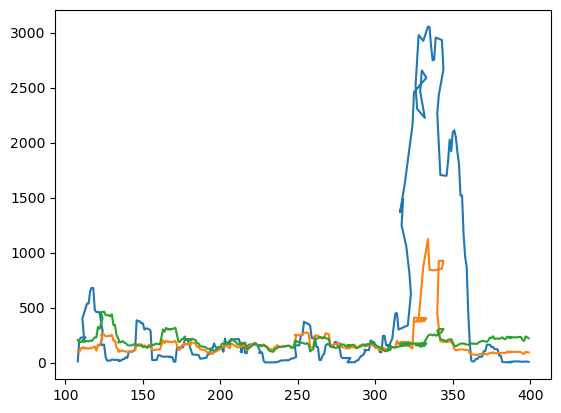

In [57]:
# We can really see that the arbitrage profit theorethical is very linked with the gas payed for transaction on the exchange
# The gas cost is higher that the profits made because we only look at arbitrage on a given pool 
# but usually uniswap alows a multicall if you want to perform a swap transaction accross multiple pools simultanously
# in this you can bundle all the swap into one transaction so you would pay for one tx instead of multiple 
# then arbitragers are also look ing for additional profits on other pools 

(2*data['arb_pnl']).abs().rolling(10).sum().head(300).plot()

data['tcost_usd'].rolling(10).sum().head(300).plot()

# recompute the avg_gas taking all transactions from the block even if they dont want to trade on the pool
data['avg_gas'].rolling(10).sum().head(300).plot()

<Axes: >

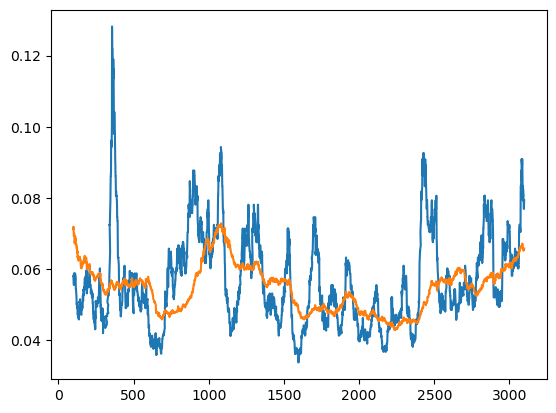

In [58]:
data['lambda_1min'].head(3000).plot()
data['lambda_5min'].head(3000).plot()

In [34]:
X = data_filtered[features]
y = data_filtered[target]

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

feature_importances = np.zeros((n_splits, len(features)))

fold = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    feature_importances[fold, :] = model.feature_importances_
    fold += 1

avg_feature_importances = feature_importances.mean(axis=0)

normalized_avg_feature_importances = avg_feature_importances / avg_feature_importances.sum()

# Create a dictionary of features and their normalized average importance
features_importance_normalized_avg = {feature: importance for feature, importance in zip(features, normalized_avg_feature_importances)}
print("\nNormalized Average Feature Importances Across Folds:")
for feature, importance in features_importance_normalized_avg.items():
    print(f"{feature}: {importance:.4f}")



Normalized Average Feature Importances Across Folds:
LVR_nbtoken: 0.1009
LVR: 0.0911
std: 0.1001
mean_rol_amount: 0.0703
avg_gas: 0.3041
price_impact: 0.0137
rol_amountUSD: 0.1097
lambda: 0.0560
rolling_time_span: 0.0521
amountUSD: 0.1020


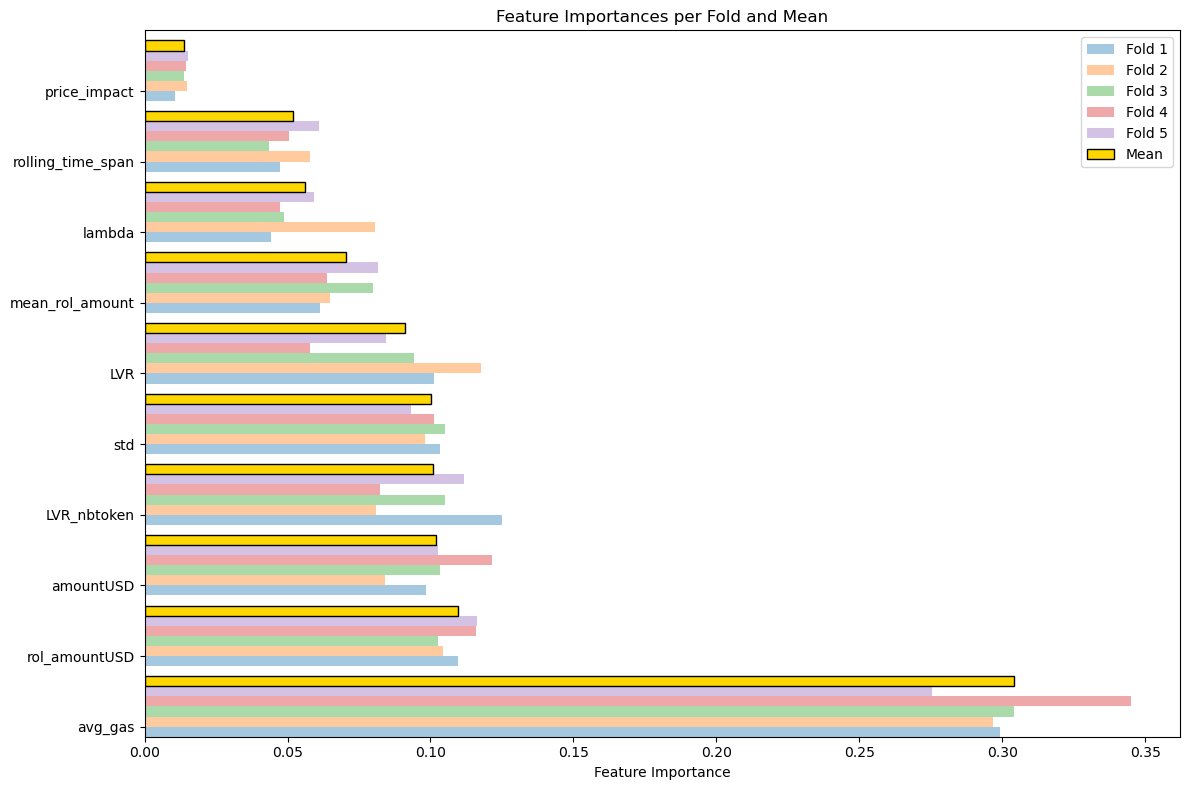

In [35]:
# Compute the mean feature importance and sort features based on it
mean_feature_importances = np.mean(feature_importances, axis=0)
sorted_idx = np.argsort(mean_feature_importances)[::-1]

n_features = len(features)
n_folds = feature_importances.shape[0]
fig, ax = plt.subplots(figsize=(12, 8))

width = 1 / (n_folds + 2)  # +2 for spacing and the mean

# Create a bar plot for each fold's feature importance + mean feature importance
for fold in range(n_folds):
    fold_importances_sorted = feature_importances[fold, sorted_idx]
    ax.barh(np.arange(n_features) - width / 2 + fold * width, fold_importances_sorted, height=width, label=f'Fold {fold+1}', alpha=0.4)

mean_importances_sorted = mean_feature_importances[sorted_idx]
ax.barh(np.arange(n_features) - width / 2 + n_folds * width, mean_importances_sorted, height=width, color='gold', edgecolor='black', label='Mean')

ax.set(yticks=np.arange(n_features), yticklabels=np.array(features)[sorted_idx], ylim=(-width, n_features - width))
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importances per Fold and Mean')
ax.legend()

plt.tight_layout()
plt.show()


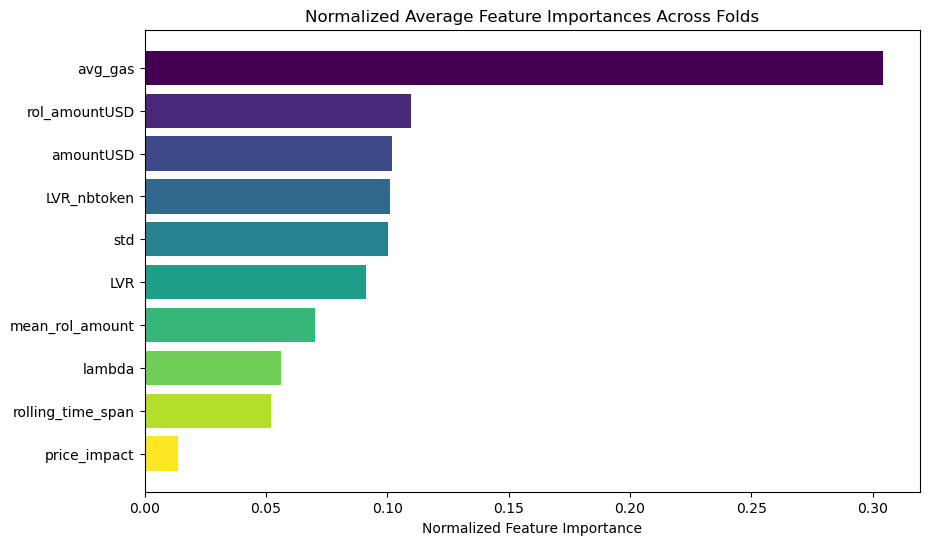

In [36]:
# Assuming 'features_importance_normalized_avg' contains your normalized average feature importances
features = list(features_importance_normalized_avg.keys())
normalized_importances = list(features_importance_normalized_avg.values())

# Sorting features by their importances for better visualization
sorted_indices = sorted(range(len(normalized_importances)), key=lambda i: normalized_importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [normalized_importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(features))))
plt.xlabel('Normalized Feature Importance')
plt.title('Normalized Average Feature Importances Across Folds')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


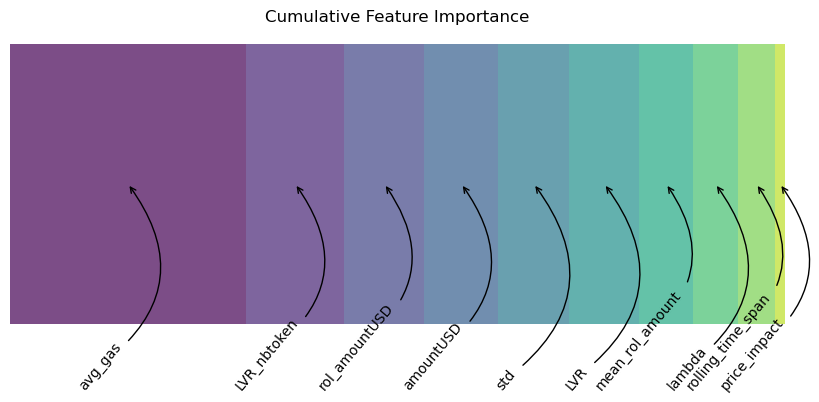

In [37]:
# Assuming 'features_importance_normalized' is your dictionary with your features and their normalized importances
features = list(features_importance_normalized_avg.keys())
importances = list(features_importance_normalized_avg.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plot setup
plt.figure(figsize=(10, 4))  # Adjust the figure size as necessary
cumulative_importances = [sum(sorted_importances[:i+1]) for i in range(len(sorted_importances))]
starts = [0] + cumulative_importances[:-1]  # Starting point for each feature's bar section

# Create a stacked bar plot with annotations
for i, feature in enumerate(sorted_features):
    plt.barh(' ', sorted_importances[i], left=starts[i], color=plt.cm.viridis(i / len(sorted_features)), alpha=0.7)
    # Annotate each bar section with the feature name
    plt.annotate(feature, 
                 xy=(starts[i] + sorted_importances[i] / 2, 0), 
                 xytext=(-20, -150),  # Adjust as needed
                 textcoords="offset points",
                 ha='center', va='bottom',
                 rotation=50,  # Adjust as needed
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"))

plt.xlabel('Normalized Feature Importance')
plt.title('Cumulative Feature Importance')
plt.xlim(0, 1)  # Ensure the x-axis goes from 0 to 1 to represent the full 100% of importances
plt.axis('off')  # Turn off the axis for a cleaner look
plt.show()


In [38]:
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:    
    # here for each features the parameters of the sigmoid will be the one to calibrate
    buy_subset[f'{f}_fee']  = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, params[f]['f_min'], params[f]['f_max'], params[f]['k'], params[f]['x0']))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, params[f]['f_min'], params[f]['f_max'], k, params[f]['x0']))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized_avg[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)
combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']


In [39]:
# check the fee is correctly computed for each features
combined_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,std_weighted_fee,mean_rol_amount_weighted_fee,avg_gas_weighted_fee,price_impact_weighted_fee,rol_amountUSD_weighted_fee,lambda_weighted_fee,rolling_time_span_weighted_fee,amountUSD_weighted_fee,combined_fee,target_fee_usd
1993,2149.335951,-0.933970,2146.204418,0x50afb13da153d0fbcaa9fe8192ef8de0ad19bf47,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704104e+09,567759,9.942225e+09,9.942225e-09,...,0.007409,0.006894,0.030399,0.000283,0.010279,0.001277,0.004762,0.009588,0.077621,1562.594938
1996,2255.267607,-0.980008,2251.988988,0x718ef36402308fa4464d4471597d5a78f9e4d990,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704104e+09,323696,1.083646e+10,1.083646e-08,...,0.007144,0.006894,0.030399,0.000283,0.010279,0.001277,0.004762,0.009588,0.074567,1295.902186
1999,24116.167226,-10.478967,24080.519228,0x16c473448e770ff647c69cbe19e28528877fba1b,0xe592427a0aece92de3edee1f18e0157c05861564,0x9008d19f58aabd9ed0d60971565aa8510560ab41,1.704104e+09,1859200,1.057699e+10,1.057699e-08,...,0.006878,0.006894,0.030399,0.000283,0.010279,0.001277,0.004762,0.009588,0.074115,2480.232544
2013,2559.167139,-1.112658,2556.127621,0x1a63f5e18b57ddee7ac21dcc39bcb13b9f8439b8,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704104e+09,415111,1.021987e+10,1.021987e-08,...,0.005734,0.006894,0.030399,0.000283,0.010279,0.001277,0.004762,0.009588,0.075225,1319.274399
2153,1635.036058,-0.709486,1632.614656,0xf918f33cdee424f8e2ea86313e3ececc7ba01cc5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704108e+09,408022,1.262669e+10,1.262669e-08,...,0.004502,0.006894,0.030399,0.000283,0.010279,0.001276,0.004762,0.009588,0.071859,1292.764827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187164,-4498.593378,1.969426,4494.298980,0x0b80c366d3d92fcd4de0d4a3d596ced82edcf65d,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706744e+09,340082,3.127184e+10,3.127184e-08,...,-0.001111,-0.000689,-0.003040,-0.000283,-0.001028,-0.001150,-0.000476,-0.000959,-0.016711,2461.149108
187165,-2166.828694,0.948623,2164.775137,0x62e0135c670b1ae94a03afc9826b28404ad17109,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x62e0135c670b1ae94a03afc9826b28404ad17109,1.706744e+09,314430,2.206554e+10,2.206554e-08,...,-0.001126,-0.000689,-0.003040,-0.000283,-0.001028,-0.001150,-0.000476,-0.000959,-0.014617,1189.244867
187220,-4281.501296,1.877463,4280.921566,0xf865067a5b9672f11af8514440d9111afd05d040,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,606426,2.448898e+10,2.448898e-08,...,-0.001052,-0.000689,-0.003040,-0.000285,-0.001028,-0.001150,-0.000476,-0.000959,-0.014828,1482.463783
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,-0.001042,-0.000689,-0.003040,-0.000283,-0.001028,-0.001150,-0.000476,-0.000959,-0.014023,859.874628


In [45]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'LVR'                 : 'sum',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'sum',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee'] * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'] / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'] / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,LVR,impermanent_loss,tcost_usd,...,cpnl,dpnl,fees_cumul,avg_7m_volume,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_7m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_7m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 13:17:00,2302.879452,2302.879452,2302.879452,2302.879452,-1478.491453,0.642350,1477.744322,0.886795,0.000000e+00,19.161289,...,0.738872,37.817408,55.792961,4.394901,28.510747,0.0,-0.153024,10124.645616,0.0,-0.000406
2024-01-01 13:18:00,2302.879452,2302.879452,2302.879452,2302.879452,14899.513588,-6.464241,27078.392229,-6.189643,0.000000e+00,46.495609,...,13.539196,932.564155,69.332158,5.530495,37.511033,0.0,-0.149423,10684.390316,0.0,-0.000406
2024-01-01 13:19:00,2302.879452,2302.879452,2302.879452,2302.879452,-1071.543167,0.465542,1070.996838,0.619426,0.000000e+00,9.979610,...,2.378447,15.405829,69.867656,5.590555,28.677489,0.0,-0.119764,5850.442159,0.0,-0.000261
2024-01-01 13:21:00,2304.261525,2304.722401,2304.261525,2304.722401,49353.570060,-21.410436,50713.322884,-15.262692,-4.999500e-09,13.946786,...,25.587134,3020.689823,95.224317,8.860278,43.451165,0.0,-0.090464,4022.338922,0.0,-0.000133
2024-01-01 13:22:00,2304.952873,2304.952873,2304.952873,2304.952873,-5278.321730,2.291309,5273.438115,1.122179,0.000000e+00,42.594207,...,2.406247,202.419158,97.861036,7.701000,44.649896,0.0,-0.066799,4208.896373,0.0,-0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 22:39:00,2281.106770,2281.563014,2281.106770,2281.563014,7720.145540,-3.375847,32253.267190,-6.714486,-1.249875e-09,86.822303,...,16.126634,1347.612145,105462.581610,17.158311,57.910396,0.0,-0.004639,6256.732370,0.0,0.000000
2024-01-31 22:40:00,2281.563014,2281.563014,2281.563014,2281.563014,-3969.855780,1.740919,3967.606641,0.074947,0.000000e+00,186.341550,...,1.983803,157.001146,105464.565413,12.300530,54.411662,0.0,-0.001224,5876.328221,0.0,0.000000
2024-01-31 22:41:00,2281.563014,2281.563014,2281.563014,2281.563014,-11008.121934,4.831965,30985.693922,-2.285588,0.000000e+00,73.363984,...,18.003822,1411.472856,105480.058260,10.020820,70.621814,0.0,-0.000938,7255.719434,0.0,0.000000


<Axes: xlabel='time_dex'>

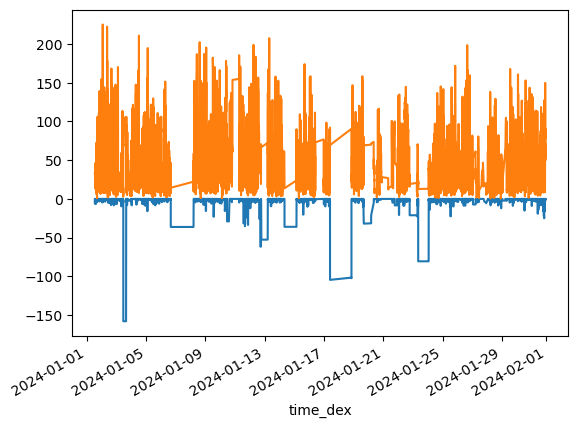

In [41]:
metrics['cpnl_5m_negative'].plot()
metrics['cpnl_5m_positive'].plot()

<Axes: xlabel='time_dex'>

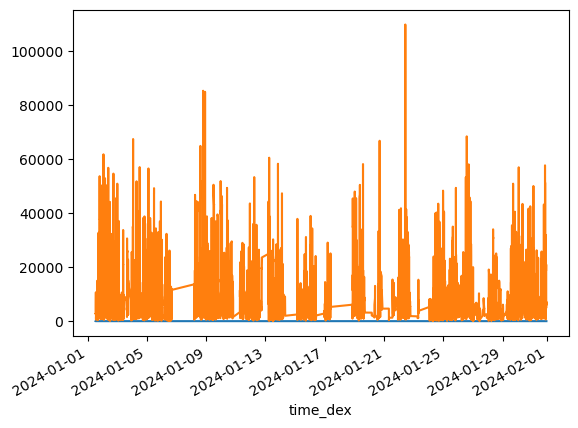

In [42]:
metrics['dpnl_5m_negative'].plot()
metrics['dpnl_5m_positive'].plot()

In [43]:
print(f"The total constant fees are: {round(metrics['cfee'].sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")

The total constant fees are: 105502.55
The total dynamic  fees are: 17865975.58

The total pnl with c are: 105475.05
The total pnl with d are: 21573944.32


In [46]:
metrics['d%_toxic_flow_ma_7m'].sum()

-0.26702949134707754

In [47]:
metrics['c%_toxic_flow_ma_7m'].sum()

4753.730769298448

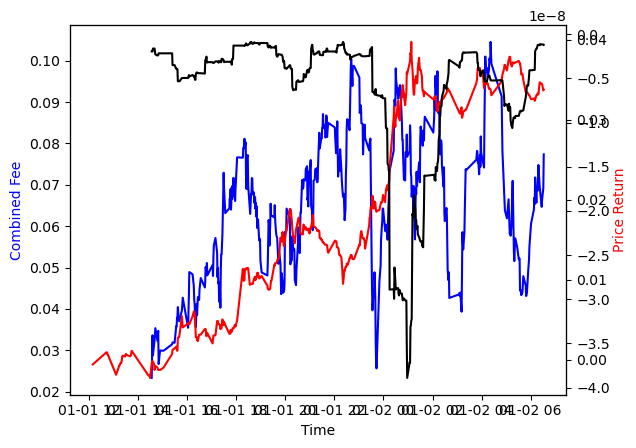

In [48]:
# after aggregating the swap on a minute level here is the time series of the fee we charge

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(metrics['combined_fee'].rolling(30).mean().head(500), color='blue')
ax2.plot(metrics['close'].pct_change().cumsum().head(500), color='red')
ax3.plot(metrics['impermanent_loss'].rolling(30).mean().head(500), color='black')

ax1.set_xlabel('Time')
ax1.set_ylabel('Combined Fee', color='blue')
ax2.set_ylabel('Price Return', color='red')

plt.show()


In [49]:
# plot correlation of the dynamic fee with the factore we consider in the model
# plot also the temporal rolling graphs of the features and the fees to see they mve together

In [59]:
# only 9% of the fees that we quote are in the range of the fee the arbitrager will be willing to pay
accuracy = (metrics['dfee'].abs() < metrics['tcost_usd']).mean()
accuracy

0.09164516416051251

In [60]:
combined_data.columns

Index(['amount0', 'amount1', 'amountUSD', 'origin', 'sender', 'recipient',
       'timestamp', 'gasUsed', 'gasPrice_wei', 'gasPrice_eth', 'blockNumber',
       'symbol0', 'symbol1', 'price_dex', 'tcost_usd', 'time', 'time_dex',
       'price_cex', 'time_cex', 'LVR_clean', 'LVR_clean_cumm', 'LVR',
       'LVR_cumm', 'impermanent_loss', 'LVR_nbtoken', 'avg_gas', 'arb_fee',
       'LVR_zscore', 'std', 'mean_rol_amount', 'rol_amountUSD', 'price_impact',
       'rolling_time_span', 'rolling_trade_count', 'lambda', 'target_fee',
       'LVR_nbtoken_fee', 'LVR_fee', 'std_fee', 'mean_rol_amount_fee',
       'avg_gas_fee', 'price_impact_fee', 'rol_amountUSD_fee', 'lambda_fee',
       'rolling_time_span_fee', 'amountUSD_fee', 'LVR_nbtoken_weighted_fee',
       'LVR_weighted_fee', 'std_weighted_fee', 'mean_rol_amount_weighted_fee',
       'avg_gas_weighted_fee', 'price_impact_weighted_fee',
       'rol_amountUSD_weighted_fee', 'lambda_weighted_fee',
       'rolling_time_span_weighted_fee', 'amoun